# Import libraries

In [1]:
import os
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.cm as cm

import seaborn as sns

from numpy.polynomial.polynomial import Polynomial

from scipy.signal import savgol_filter

from sklearn.preprocessing import MinMaxScaler

In [2]:
warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', 50)

In [3]:
path_to_save_data = './../data/preprocessed_data'
path_to_save = './../results/01_visualization'

# Loading & parsing data

In [4]:
path_to_ftir = './../data'

In [5]:
files = [file for file in os.listdir(path_to_ftir) if file.endswith(".dpt")] # list of all files

files = sorted(
    files,
    key=lambda x: (
        x.split("_")[0].replace(".", "").isnumeric(),
        float(x.split("_")[0]) if x.split("_")[0].replace(".", "").isnumeric() else x
    )
)


spectra_dict = {}

for file in files:
    file_path = os.path.join(path_to_ftir, file)
    fraction_name = file.split("_")[0]


    try:
        df = pd.read_csv(file_path, sep=",", header=None)
        wavenumbers = df[0].values  # first column is wavenumber
        intensities = df[1].values  # second columns is intensities

        spectra_dict[fraction_name] = intensities

    except Exception as e:
        print(f"Ошибка при чтении {file_path}: {e}")

initial_data = pd.DataFrame.from_dict(
    spectra_dict,
    orient="index",
    columns=wavenumbers
)

initial_data.index.name = "Fraction"

print(initial_data.shape)
initial_data.head(3)

(8, 3733)


,3998.31069,3997.34631,3996.38194,3995.41756,3994.45318,3993.48880,3992.52442,3991.56005,3990.59567,3989.63129,3988.66691,3987.70253,3986.73816,3985.77378,3984.80940,3983.84502,3982.88065,3981.91627,3980.95189,3979.98751,3979.02313,3978.05876,3977.09438,3976.13000,3975.16562,...,422.39751,421.43313,420.46876,419.50438,418.54000,417.57562,416.61124,415.64687,414.68249,413.71811,412.75373,411.78935,410.82498,409.86060,408.89622,407.93184,406.96747,406.00309,405.03871,404.07433,403.10995,402.14558,401.18120,400.21682,399.25244
Fraction,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
bulk,0.052193,0.052193,0.052193,0.052193,0.052193,0.052193,0.052193,0.052148,0.052103,0.052127,0.052163,0.052133,0.052031,0.051901,0.051774,0.051755,0.051840,0.051951,0.051994,0.051923,0.051900,0.051961,0.052027,0.052045,0.052011,...,0.030127,0.030325,0.030319,0.030221,0.030048,0.029785,0.029506,0.029192,0.028770,0.028500,0.028552,0.028690,0.028771,0.028741,0.028640,0.028492,0.028340,0.028189,0.028004,0.028004,0.028004,0.028004,0.028004,0.028004,0.028004
0.4,-0.001145,-0.001145,-0.001145,-0.001145,-0.001145,-0.001145,-0.001145,-0.001097,-0.001102,-0.001139,-0.001140,-0.001171,-0.001244,-0.001316,-0.001380,-0.001349,-0.001280,-0.001247,-0.001231,-0.001253,-0.001306,-0.001385,-0.001414,-0.001381,-0.001335,...,0.000822,0.000844,0.000849,0.000856,0.000832,0.000785,0.000736,0.000695,0.000610,0.000532,0.000595,0.000708,0.000819,0.000914,0.000932,0.000871,0.000810,0.000739,0.000596,0.000596,0.000596,0.000596,0.000596,0.000596,0.000596
2,-0.007497,-0.007497,-0.007497,-0.007497,-0.007497,-0.007497,-0.007497,-0.007444,-0.007425,-0.007431,-0.007416,-0.007411,-0.007465,-0.007554,-0.007648,-0.007655,-0.007586,-0.007531,-0.007522,-0.007558,-0.007594,-0.007605,-0.007577,-0.007583,-0.007643,...,0.002214,0.002280,0.002228,0.002113,0.001997,0.001888,0.001746,0.001543,0.001309,0.001219,0.001324,0.001480,0.001638,0.001708,0.001659,0.001603,0.001645,0.001685,0.001588,0.001588,0.001588,0.001588,0.001588,0.001588,0.001588


# Data preprocessing

# Baseline correction

In [6]:
data = initial_data.copy()

for idx in data.index:
    coefs = Polynomial.fit(data.columns, data.loc[idx], deg=2).convert().coef
    baseline = np.polyval(coefs[::-1], data.columns)
    
    corrected_intensity = data.loc[idx] - baseline
    corrected_intensity -= corrected_intensity.min()
    
    data.loc[idx] = corrected_intensity

print(data.shape)
data.head(3)

(8, 3733)


,3998.31069,3997.34631,3996.38194,3995.41756,3994.45318,3993.48880,3992.52442,3991.56005,3990.59567,3989.63129,3988.66691,3987.70253,3986.73816,3985.77378,3984.80940,3983.84502,3982.88065,3981.91627,3980.95189,3979.98751,3979.02313,3978.05876,3977.09438,3976.13000,3975.16562,...,422.39751,421.43313,420.46876,419.50438,418.54000,417.57562,416.61124,415.64687,414.68249,413.71811,412.75373,411.78935,410.82498,409.86060,408.89622,407.93184,406.96747,406.00309,405.03871,404.07433,403.10995,402.14558,401.18120,400.21682,399.25244
Fraction,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
bulk,0.000167,0.000186,0.000204,0.000222,0.000240,0.000258,0.000276,0.000249,0.000222,0.000264,0.000318,0.000306,0.000222,0.000110,9.915570e-07,0.000000,0.000103,0.000232,0.000293,0.000240,0.000236,0.000315,0.000398,0.000435,0.000418,...,0.012721,0.012919,0.012914,0.012817,0.012644,0.012382,0.012104,0.011790,0.011369,0.011099,0.011151,0.011290,0.011372,0.011343,0.011242,0.011095,0.010943,0.010792,0.010608,0.010608,0.010609,0.010609,0.010610,0.010610,0.010611
0.4,0.001917,0.001916,0.001914,0.001913,0.001911,0.001910,0.001908,0.001955,0.001948,0.001910,0.001907,0.001874,0.001800,0.001727,1.660655e-03,0.001691,0.001758,0.001789,0.001804,0.001781,0.001726,0.001646,0.001615,0.001647,0.001691,...,0.002742,0.002765,0.002771,0.002779,0.002755,0.002709,0.002662,0.002621,0.002537,0.002460,0.002524,0.002639,0.002750,0.002846,0.002865,0.002805,0.002745,0.002675,0.002533,0.002534,0.002535,0.002536,0.002537,0.002538,0.002539
2,0.001210,0.001205,0.001199,0.001194,0.001189,0.001184,0.001179,0.001226,0.001240,0.001229,0.001239,0.001238,0.001179,0.001085,9.863671e-04,0.000974,0.001038,0.001088,0.001091,0.001051,0.001009,0.000994,0.001016,0.001005,0.000940,...,0.001901,0.001967,0.001916,0.001800,0.001685,0.001577,0.001435,0.001232,0.000998,0.000908,0.001014,0.001171,0.001329,0.001399,0.001351,0.001295,0.001337,0.001377,0.001281,0.001281,0.001282,0.001282,0.001282,0.001283,0.001283


## Smoothing

In [7]:
data_smoothed = data.copy()

for idx in data_smoothed.index:
    data_smoothed.loc[idx] = savgol_filter(data_smoothed.loc[idx], window_length=63, polyorder=3)

print(data_smoothed.shape)
data_smoothed.head(3)

(8, 3733)


,3998.31069,3997.34631,3996.38194,3995.41756,3994.45318,3993.48880,3992.52442,3991.56005,3990.59567,3989.63129,3988.66691,3987.70253,3986.73816,3985.77378,3984.80940,3983.84502,3982.88065,3981.91627,3980.95189,3979.98751,3979.02313,3978.05876,3977.09438,3976.13000,3975.16562,...,422.39751,421.43313,420.46876,419.50438,418.54000,417.57562,416.61124,415.64687,414.68249,413.71811,412.75373,411.78935,410.82498,409.86060,408.89622,407.93184,406.96747,406.00309,405.03871,404.07433,403.10995,402.14558,401.18120,400.21682,399.25244
Fraction,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
bulk,0.000172,0.000179,0.000186,0.000193,0.000200,0.000207,0.000214,0.000220,0.000227,0.000234,0.000240,0.000247,0.000253,0.000260,0.000267,0.000273,0.000280,0.000287,0.000294,0.000302,0.000309,0.000317,0.000325,0.000333,0.000341,...,0.012228,0.012172,0.012114,0.012055,0.011993,0.011930,0.011865,0.011797,0.011728,0.011656,0.011582,0.011506,0.011427,0.011346,0.011262,0.011176,0.011087,0.010996,0.010901,0.010804,0.010704,0.010601,0.010495,0.010386,0.010274
0.4,0.001941,0.001931,0.001921,0.001911,0.001901,0.001891,0.001882,0.001872,0.001863,0.001854,0.001845,0.001836,0.001827,0.001818,0.001810,0.001802,0.001794,0.001786,0.001779,0.001772,0.001765,0.001759,0.001753,0.001747,0.001742,...,0.002647,0.002656,0.002664,0.002672,0.002679,0.002685,0.002690,0.002694,0.002697,0.002699,0.002699,0.002697,0.002694,0.002690,0.002683,0.002675,0.002664,0.002651,0.002637,0.002619,0.002600,0.002578,0.002553,0.002525,0.002495
2,0.001271,0.001250,0.001231,0.001212,0.001196,0.001180,0.001166,0.001153,0.001141,0.001131,0.001121,0.001113,0.001105,0.001099,0.001093,0.001088,0.001084,0.001081,0.001079,0.001077,0.001076,0.001075,0.001075,0.001075,0.001076,...,0.001396,0.001399,0.001401,0.001403,0.001404,0.001404,0.001404,0.001403,0.001401,0.001398,0.001394,0.001389,0.001382,0.001375,0.001366,0.001356,0.001344,0.001330,0.001315,0.001299,0.001280,0.001260,0.001238,0.001213,0.001187


## Wavenumber range selection

In [8]:
data_smoothed_selected = data_smoothed.loc[:, (data_smoothed.columns >= 800) & (data_smoothed.columns <= 1900)]

print(data_smoothed_selected.shape)
data_smoothed_selected.head(3)

(8, 1141)


,1899.82442,1898.86005,1897.89567,1896.93129,1895.96691,1895.00253,1894.03816,1893.07378,1892.10940,1891.14502,1890.18065,1889.21627,1888.25189,1887.28751,1886.32313,1885.35876,1884.39438,1883.43000,1882.46562,1881.50124,1880.53687,1879.57249,1878.60811,1877.64373,1876.67935,...,823.57871,822.61433,821.64995,820.68558,819.72120,818.75682,817.79244,816.82806,815.86369,814.89931,813.93493,812.97055,812.00618,811.04180,810.07742,809.11304,808.14866,807.18429,806.21991,805.25553,804.29115,803.32677,802.36240,801.39802,800.43364
Fraction,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
bulk,0.002106,0.002089,0.002077,0.002074,0.002079,0.002088,0.002100,0.002108,0.002112,0.002114,0.002116,0.002118,0.002122,0.002130,0.002142,0.002160,0.002180,0.002199,0.002214,0.002223,0.002230,0.002231,0.002223,0.002208,0.002189,...,0.012336,0.012278,0.012222,0.012168,0.012117,0.012068,0.012021,0.011976,0.011932,0.011889,0.011847,0.011807,0.011765,0.011722,0.011677,0.011631,0.011585,0.011541,0.011498,0.011458,0.011420,0.011387,0.011358,0.011330,0.011302
0.4,0.001693,0.001678,0.001663,0.001653,0.001646,0.001641,0.001639,0.001640,0.001642,0.001649,0.001657,0.001664,0.001670,0.001677,0.001686,0.001697,0.001707,0.001714,0.001716,0.001713,0.001708,0.001701,0.001689,0.001673,0.001659,...,0.002321,0.002328,0.002334,0.002337,0.002339,0.002340,0.002340,0.002340,0.002341,0.002344,0.002348,0.002354,0.002362,0.002370,0.002376,0.002381,0.002385,0.002389,0.002391,0.002393,0.002395,0.002399,0.002402,0.002405,0.002407
2,0.000595,0.000591,0.000585,0.000579,0.000573,0.000569,0.000569,0.000573,0.000580,0.000594,0.000614,0.000637,0.000661,0.000684,0.000705,0.000722,0.000738,0.000753,0.000764,0.000774,0.000784,0.000794,0.000797,0.000794,0.000786,...,0.001273,0.001277,0.001279,0.001279,0.001279,0.001279,0.001280,0.001280,0.001279,0.001279,0.001280,0.001283,0.001287,0.001292,0.001297,0.001301,0.001306,0.001312,0.001318,0.001322,0.001325,0.001327,0.001328,0.001328,0.001327


## Scaling to range [0...1]

In [9]:
data_scaled_selected = data_smoothed_selected.copy()

scaler = MinMaxScaler()

data_scaled_selected.iloc[:, :] = scaler.fit_transform(data_scaled_selected.T).T

print(data_scaled_selected.shape)
data_scaled_selected.head(3)

(8, 1141)


,1899.82442,1898.86005,1897.89567,1896.93129,1895.96691,1895.00253,1894.03816,1893.07378,1892.10940,1891.14502,1890.18065,1889.21627,1888.25189,1887.28751,1886.32313,1885.35876,1884.39438,1883.43000,1882.46562,1881.50124,1880.53687,1879.57249,1878.60811,1877.64373,1876.67935,...,823.57871,822.61433,821.64995,820.68558,819.72120,818.75682,817.79244,816.82806,815.86369,814.89931,813.93493,812.97055,812.00618,811.04180,810.07742,809.11304,808.14866,807.18429,806.21991,805.25553,804.29115,803.32677,802.36240,801.39802,800.43364
Fraction,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
bulk,0.000838,0.000392,0.000090,0.000000,0.000128,0.000382,0.000679,0.000892,0.000983,0.001026,0.001085,0.001146,0.001251,0.001455,0.001753,0.002199,0.002728,0.003209,0.003579,0.003822,0.003998,0.004030,0.003821,0.003434,0.002955,...,0.262268,0.260804,0.259376,0.257991,0.256674,0.255421,0.254223,0.253072,0.251953,0.250854,0.249787,0.248748,0.247695,0.246598,0.245442,0.244252,0.243081,0.241953,0.240869,0.239829,0.238871,0.238030,0.237280,0.236562,0.235841
0.4,0.017410,0.014897,0.012486,0.010761,0.009648,0.008833,0.008504,0.008559,0.008968,0.010035,0.011454,0.012597,0.013515,0.014658,0.016240,0.018078,0.019702,0.020802,0.021138,0.020636,0.019842,0.018698,0.016694,0.014153,0.011684,...,0.121643,0.122824,0.123747,0.124349,0.124721,0.124883,0.124886,0.124893,0.125042,0.125425,0.126151,0.127206,0.128484,0.129758,0.130799,0.131620,0.132311,0.132892,0.133327,0.133645,0.134025,0.134541,0.135079,0.135533,0.135884
2,0.005258,0.004453,0.003222,0.001846,0.000718,0.000000,0.000014,0.000740,0.002197,0.004902,0.008964,0.013629,0.018477,0.023255,0.027411,0.031005,0.034286,0.037174,0.039541,0.041473,0.043565,0.045489,0.046197,0.045593,0.043900,...,0.142617,0.143407,0.143868,0.143925,0.143851,0.143876,0.144012,0.144066,0.143943,0.143818,0.144044,0.144667,0.145554,0.146555,0.147463,0.148384,0.149469,0.150647,0.151724,0.152565,0.153185,0.153631,0.153924,0.153929,0.153610


# Data visualization

In [10]:
X_LABEL_FONT_SIZE = 14
Y_LABEL_FONT_SIZE = 14

X_TICK_FONT_SIZE = 12
Y_TICK_FONT_SIZE = 12

LEGEND_TITLE_FONT_SIZE = 12
LEGEND_FONT_SIZE = 10

## Function for data visualization

In [11]:
def plot_spectra(data_vis, y_labelpad=5, path_to_save=None):
    sns.set_theme()

    fig, ax = plt.subplots(figsize=(10, 4), dpi=300)
    
    fractions_sorted = sorted(data_vis.index, key=lambda x: float(x.replace('_um', '').replace('bulk', '1000')), reverse=True)
    
    colors = cm.bwr(np.linspace(0.2, 1.0, len(fractions_sorted)))  # coolwarm, Blues, Reds
    
    for color, fraction in zip(colors, fractions_sorted):
        
        if fraction == 'bulk':
            label = f'$> 0$'
        else:
            label = f'$< {fraction}$'
        
        ax.plot(
            data_vis.columns,
            data_vis.loc[fraction],
            label=label,
            alpha=0.8,
            color=color,
            linewidth=2
        )
    
    ax.set_xlabel(
        'Волновое число, см$^{-1}$',
        fontsize=X_LABEL_FONT_SIZE,
        labelpad=5
    )
    
    ax.set_ylabel(
        '$A$',
        fontsize=Y_LABEL_FONT_SIZE,
        labelpad=y_labelpad,
        rotation=0
    )
    
    ax.tick_params(axis='x', labelsize=X_TICK_FONT_SIZE)
    ax.tick_params(axis='y', labelsize=Y_TICK_FONT_SIZE)
    
    ax.invert_xaxis()

    ax.xaxis.set_major_locator(ticker.MultipleLocator(200))
    # ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=6))
    
    ax.yaxis.set_major_locator(ticker.MaxNLocator(nbins=12))
    
    ax.legend(
        title='Тип размерной фракции, мкм',
        title_fontsize=LEGEND_TITLE_FONT_SIZE,
        fontsize=LEGEND_FONT_SIZE,
        loc='best',
        ncol=3
    )

    plt.tight_layout()

    if path_to_save is not None:
        plt.savefig(f'{path_to_save}', dpi=600)
    
    plt.show()


## Initial spectra in range 4000-400 $cm^{–1}$

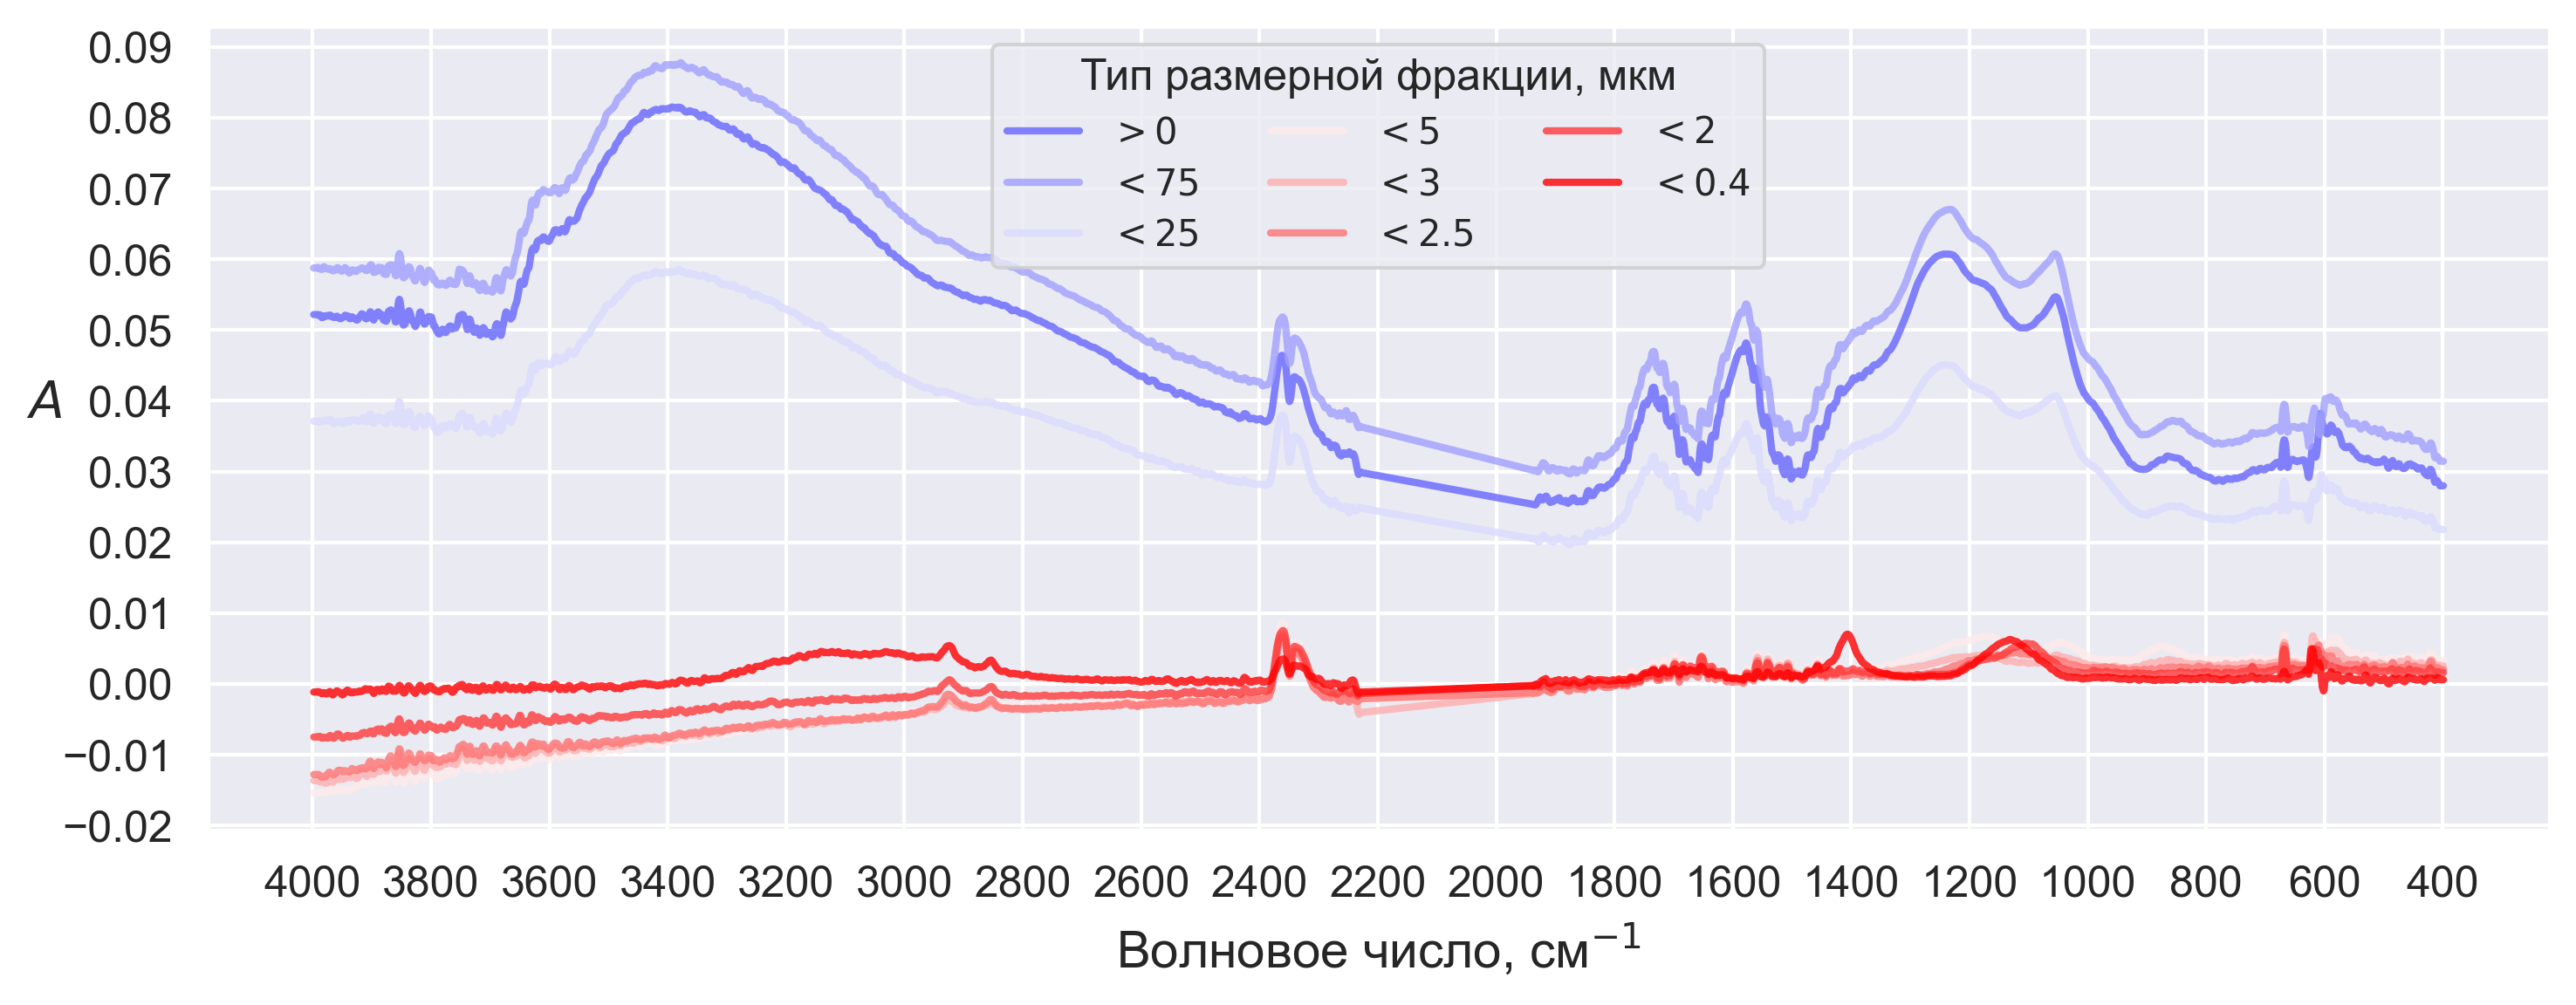

In [12]:
plot_spectra(
    data_vis=initial_data,
    y_labelpad=5,
    path_to_save=f'{path_to_save}/spectra_all_wavenumber_range.png'
)

## Spectra with correctioned baseline in range 4000-400 $cm^{–1}$

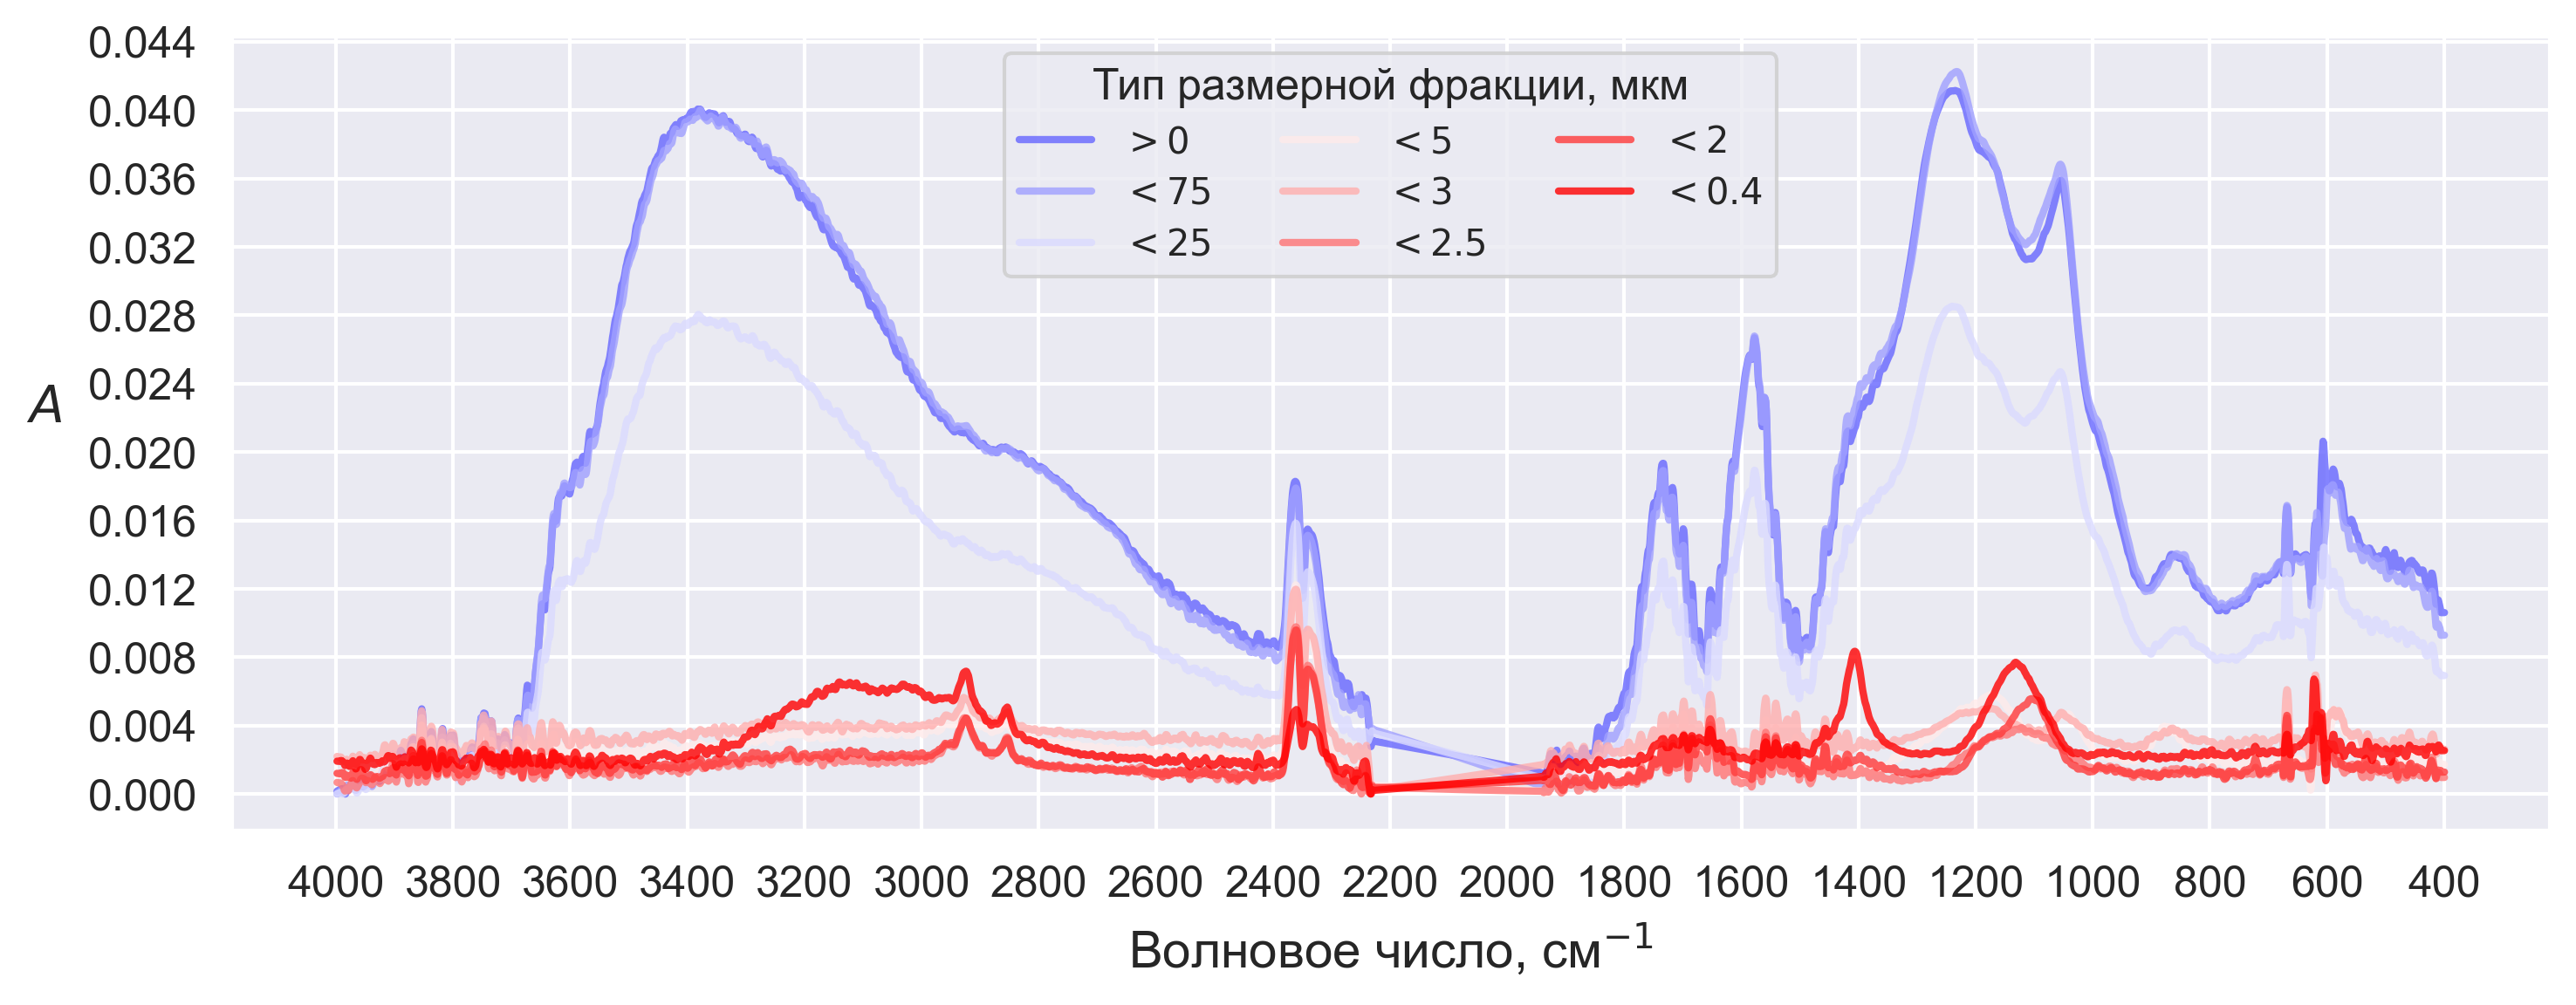

In [13]:
plot_spectra(
    data_vis=data,
    y_labelpad=12,
    path_to_save=f'{path_to_save}/spectra_baseline_corrected_all_wavenumber_range.png'
)

## Smoothed spectra in range 4000-400 $cm^{–1}$

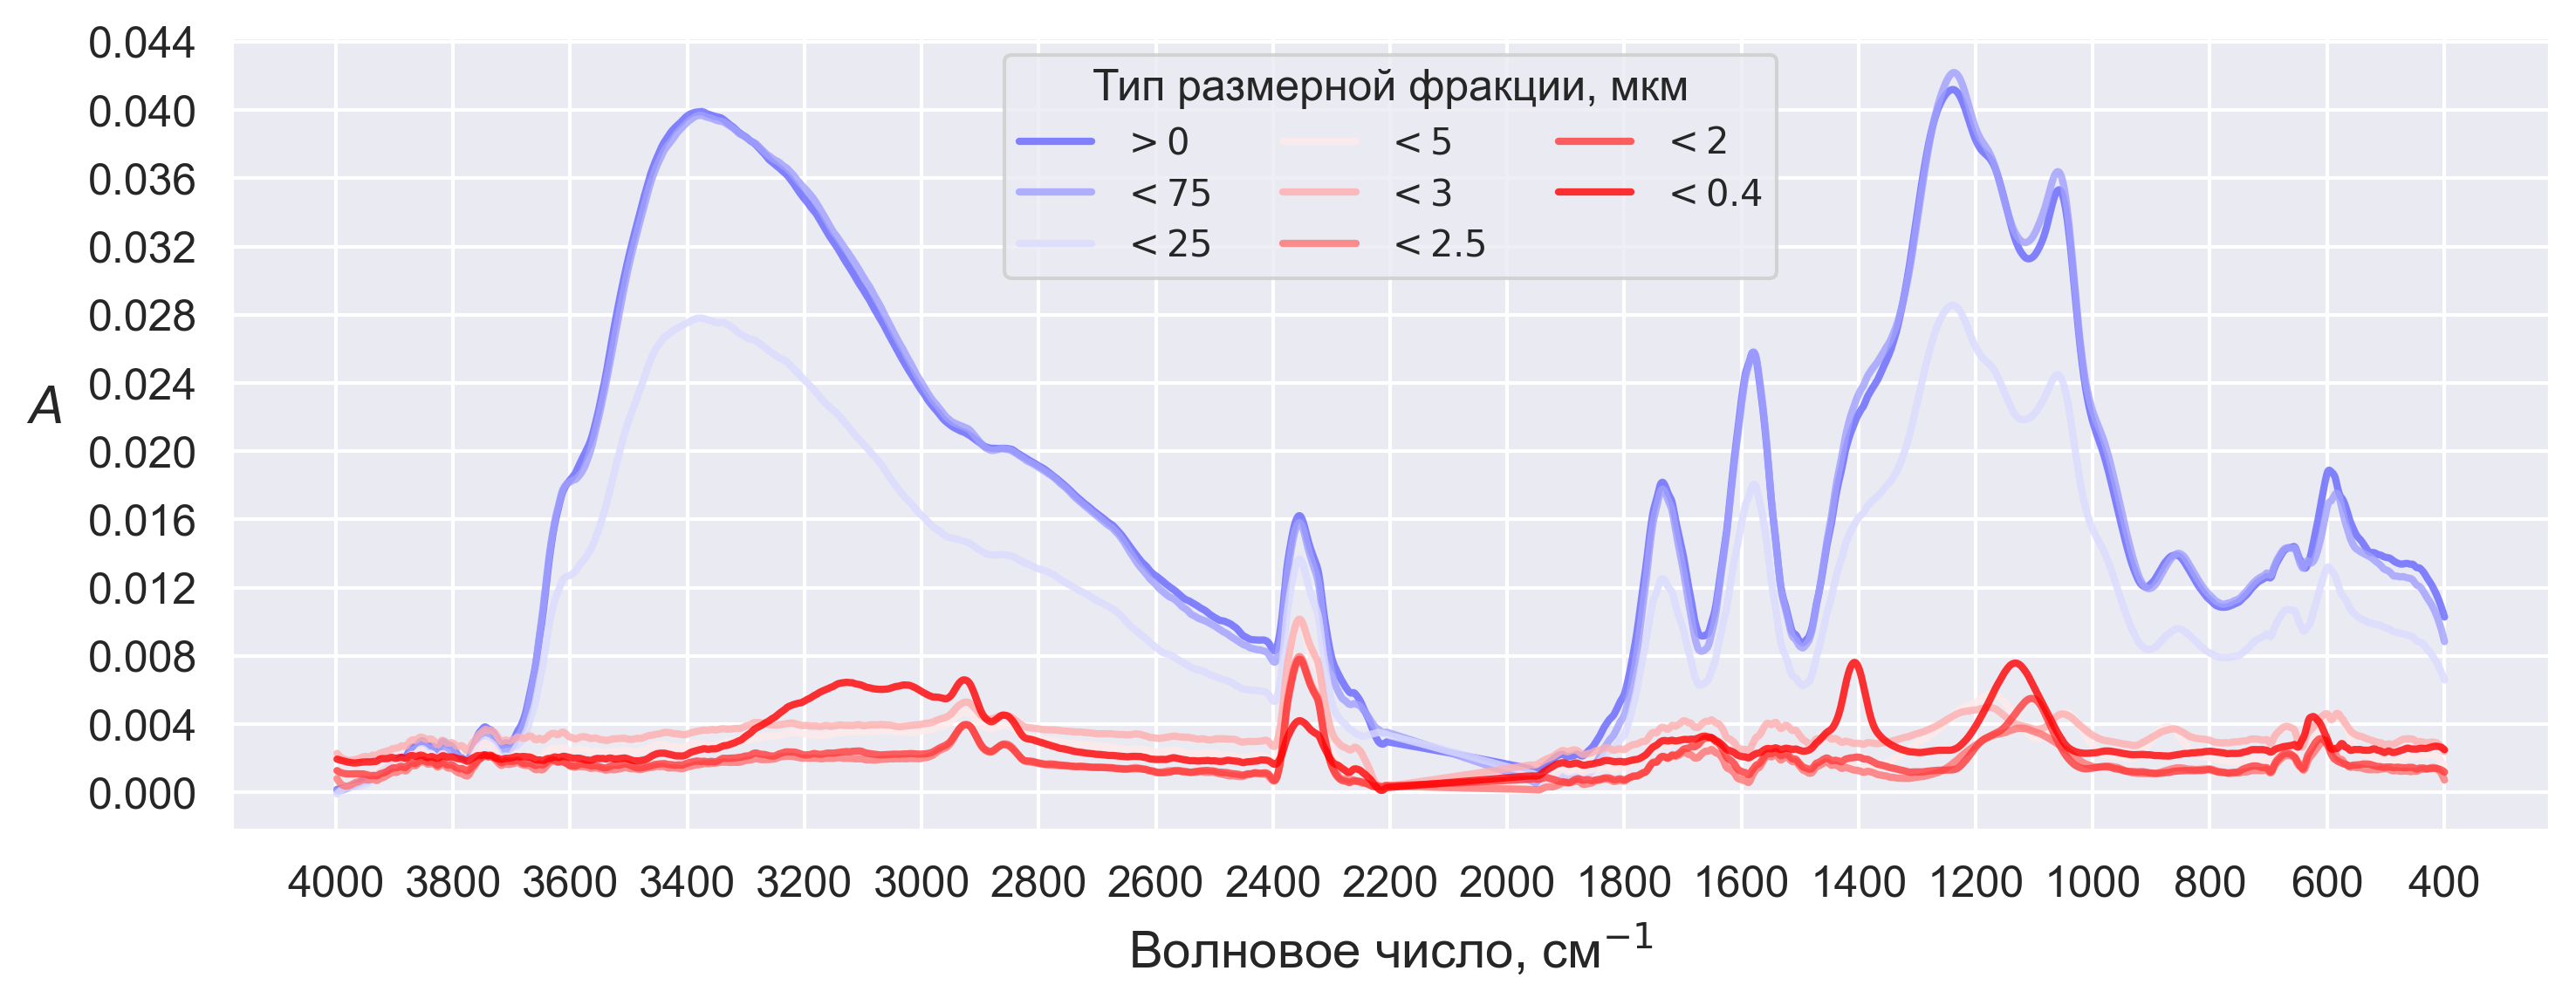

In [14]:
plot_spectra(
    data_vis=data_smoothed,
    y_labelpad=12,
    path_to_save=f'{path_to_save}/spectra_baseline_corrected_smoothed_all_wavenumber_range.png'
)

## Smoothed spectra in range 1900-800 $cm^{–1}$

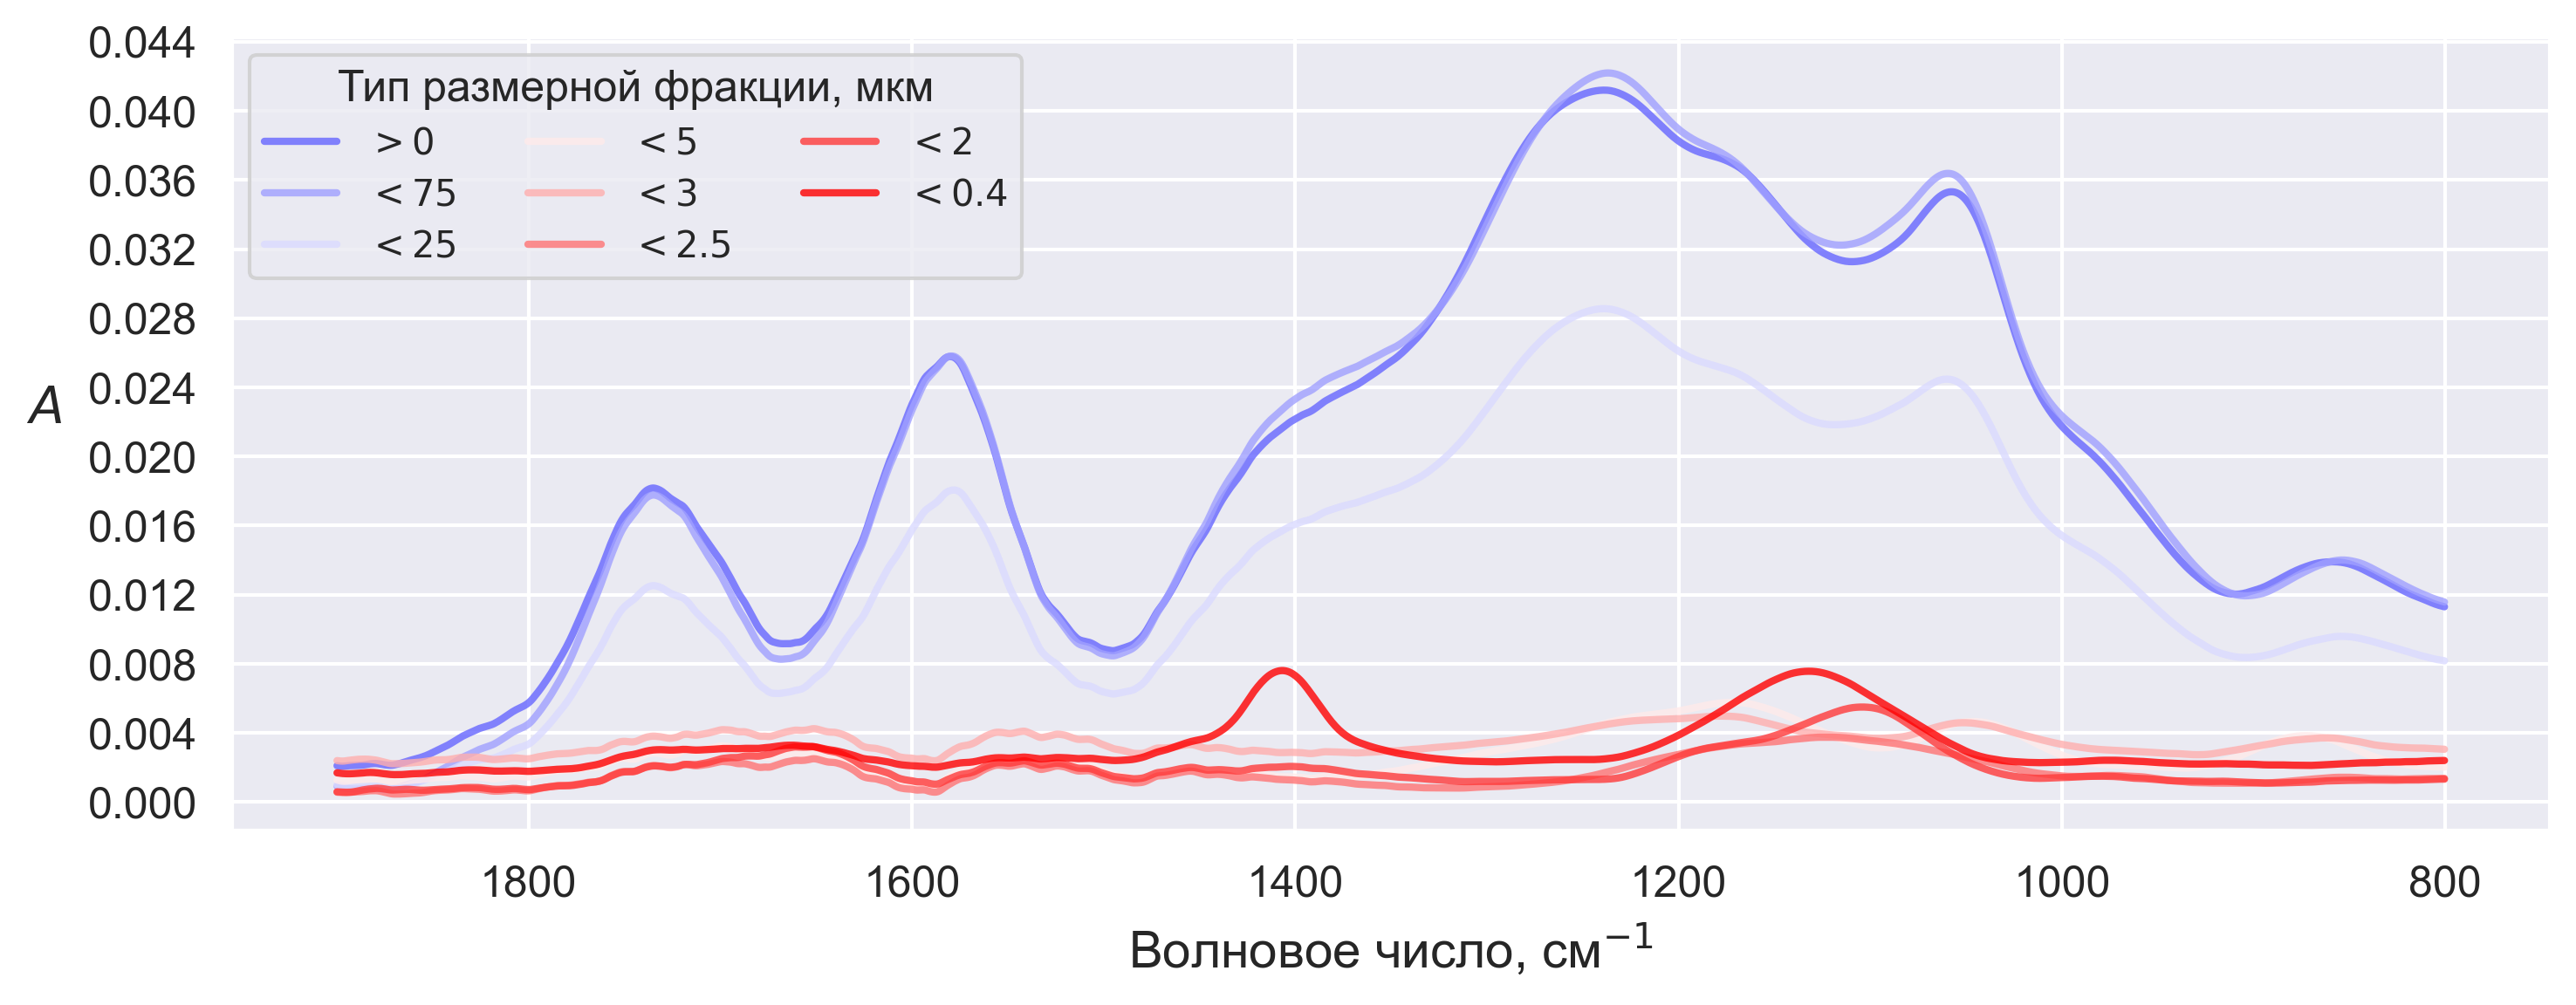

In [15]:
plot_spectra(
    data_vis=data_smoothed_selected,
    y_labelpad=12,
    path_to_save=f'{path_to_save}/spectra_baseline_corrected_smoothed_fingerprint_range.png'
)

## Smoothed spectra in range 1900-800 $cm^{–1}$

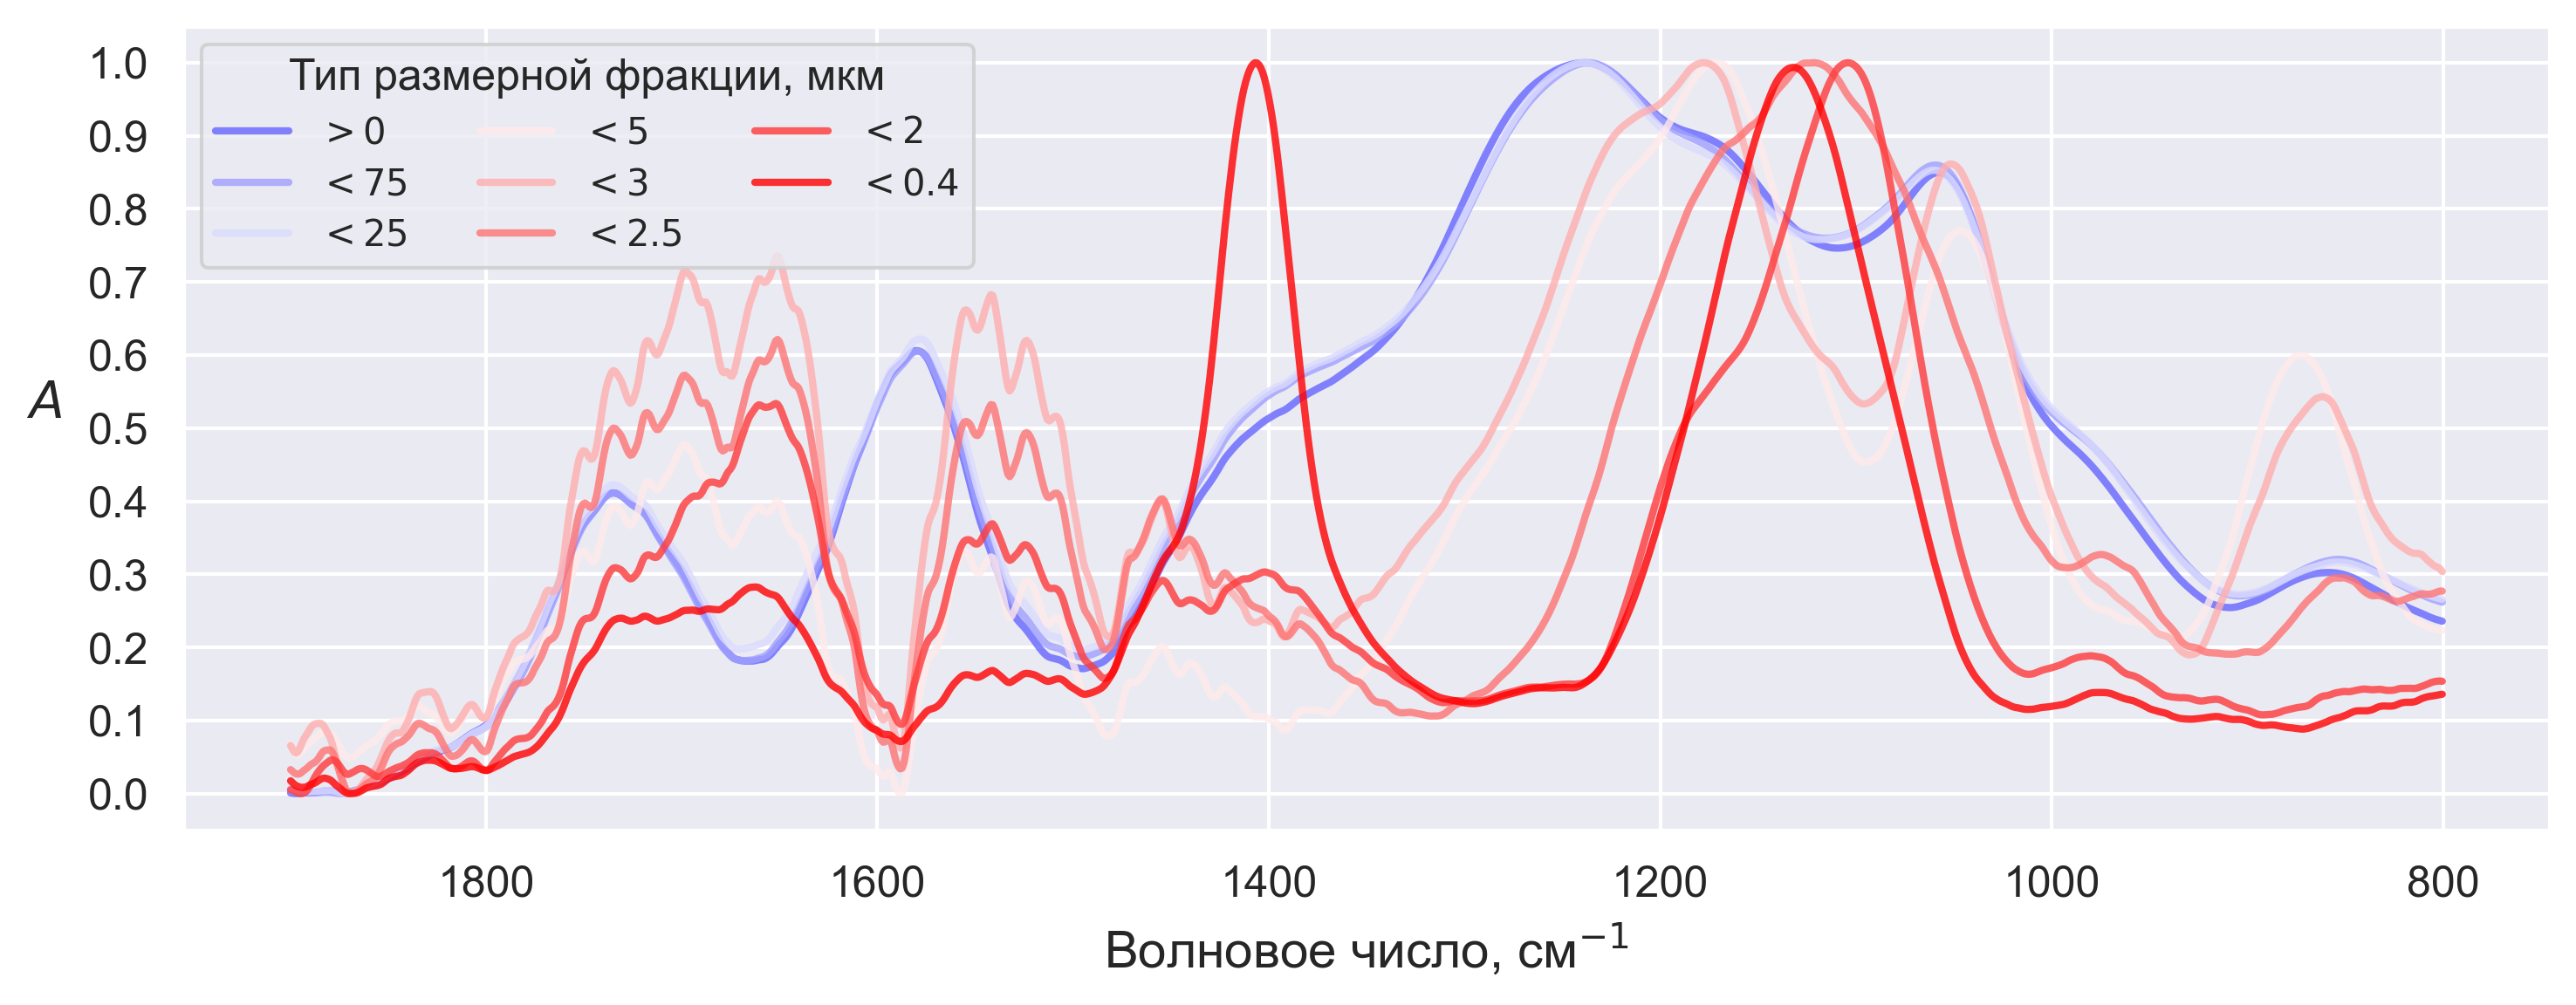

In [16]:
plot_spectra(
    data_vis=data_scaled_selected,
    y_labelpad=12,
    path_to_save=f'{path_to_save}/spectra_baseline_corrected_smoothed_scaled_fingerprint_range.png'
)

## Ad-Hoc

In [17]:
# sns.set_theme()

# fig, ax = plt.subplots(figsize=(10, 4), dpi=300)

# fractions_sorted = sorted(data_vis.index, key=lambda x: float(x.replace('_um', '').replace('bulk', '1000')), reverse=True)

# colors = cm.bwr(np.linspace(0.2, 1.0, len(fractions_sorted)))  # coolwarm, Blues, Reds

# for color, fraction in zip(colors, fractions_sorted):
    
#     if fraction == 'bulk':
#         label = f'$> 0$'
#     else:
#         label = f'$< {fraction}$'
    
#     ax.plot(
#         data_vis.columns,
#         data_vis.loc[fraction],
#         label=label,
#         alpha=0.8,
#         color=color,
#         linewidth=2
#     )

# ax.set_xlabel(
#     'Волновое число, см$^{-1}$',
#     fontstyle='normal',
#     fontsize=14,
#     labelpad=5
# )

# ax.set_ylabel(
#     '$A$',
#     fontstyle='normal',
#     fontsize=14,
#     labelpad=5,
#     rotation=0
# )

# ax.tick_params(axis='x', labelsize=12)
# ax.tick_params(axis='y', labelsize=12)

# ax.invert_xaxis()

# ax.xaxis.set_major_locator(ticker.MultipleLocator(200))
# ax.yaxis.set_major_locator(ticker.MultipleLocator(0.01))

# ax.legend(title='Размерная фракция, мкм', title_fontsize=11, fontsize=9, loc='best', ncol=3)

# plt.tight_layout()

# plt.savefig(f'{path_to_save}/spectra_in_all_wavenumber_range.png', dpi=600)

# plt.show()